
Here we include the neural network model in PyMC3, utilizing Theano tensors to reconstruct the net.

In [1]:
%pylab inline
import pymc3 as pm
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load in the neural network weights
model_numpy=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/stacked_8_element_net_large.npz")
w_array_0=np.matrix(model_numpy["w0"])
b_array_0=np.matrix(model_numpy["b0"])
w_array_1=np.matrix(model_numpy["w1"])
b_array_1=np.matrix(model_numpy["b1"])
# Load standardization parameters
input_mean=model_numpy.f.in_mean
input_std=model_numpy.f.in_std
output_mean=model_numpy.f.out_mean
output_std=model_numpy.f.out_std

In [119]:
## Load in mock dataset
mock_data=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/TNG_Mock_Data.npz') #dataset
n_stars = 40

mu_times = mock_data.f.obs_time[:n_stars] #time of birth
sigma_times = mock_data.f.obs_time_err[:n_stars] #error on age
all_els = mock_data.f.elements

full_abundances = mock_data.f.abundances[:n_stars] # chemical element abundances for data
full_errors = mock_data.f.abundance_errs[:n_stars] # error on abundances

In [120]:
# Filter out correct elements:
els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
n_els = len(els)

el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    for j in range(len(all_els)):
        if els[e]==str(all_els[j]):
            el_indices[e]=j
            break
        if j==len(all_els)-1:
            print("Failed to find element %s"%el)
obs_abundances = full_abundances[:,el_indices]
obs_errors = full_errors[:,el_indices]

In [121]:
true_Times=mock_data.f.true_time[:n_stars]
true_Lambda = [-2.3,-2.89]
true_Thetas = np.ones([n_stars,3])*np.inf # unknown

In [122]:
# Now standardize dataset
norm_data=(obs_abundances-output_mean)/output_std # use only 6 elements
norm_sd = obs_errors/output_std

In [123]:
data_obs = norm_data.ravel()
data_sd = np.asarray(norm_sd).ravel()

In [124]:
# Define priors
Lambda_prior_mean = a.p0[:2]
Theta_prior_mean = a.p0[2:]
Lambda_prior_width = [0.3,0.3]
Theta_prior_width = [0.3,0.1,0.1]
# Now standardize
std_Lambda_prior_mean = (Lambda_prior_mean-input_mean[:2])/input_std[:2]
std_Lambda_prior_width = (Lambda_prior_width)/input_std[:2]
std_Theta_prior_mean = (Theta_prior_mean-input_mean[2:5])/input_std[2:5]
std_Theta_prior_width = (Theta_prior_width)/input_std[2:5]
std_times_mean = (mu_times-input_mean[-1])/input_std[-1]
std_times_width = sigma_times/input_std[-1]

# Define critical theta edge:
log_SFR_crit = 0.29402
std_log_SFR_crit = (log_SFR_crit-input_mean[3])/input_std[3]

# Define bounds on age to stop predicting out of parameter space:
min_time,max_time = [0.,13.5]
std_min_time,std_max_time=[(time-input_mean[-1])/input_std[-1] for time in [min_time,max_time]]

In [125]:
# Define stacked local priors
Local_prior_mean = np.vstack([np.hstack([std_Theta_prior_mean,std_times_mean[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([std_Theta_prior_width,std_times_width[i]]) for i in range(n_stars)])

In [126]:
import pymc3.math as ma
import theano.tensor as tt

import os

use_model_errors = True


simple_model=pm.Model()
TruncatedNormal = pm.Bound(pm.Normal,lower=std_log_SFR_crit)
WideTruncatedNormal = pm.Bound(pm.Normal,lower=-1.5,upper=1.5) # 3sigma ranges for each parameter
AgeNormal = pm.Bound(pm.Normal,lower=std_min_time,upper=std_max_time)

# Share theano variables
w0=tt._shared(w_array_0)
b0=tt._shared(b_array_0)
w1=tt._shared(w_array_1)
b1=tt._shared(b_array_1)
ones_tensor = tt.ones([n_stars,1])

with simple_model:
    
    # Define priors
    Lambda = WideTruncatedNormal('Std-Lambda',mu=std_Lambda_prior_mean,sd=std_Lambda_prior_width,shape=(1,len(std_Lambda_prior_mean)))
    Theta1 = WideTruncatedNormal('Std-Theta1',mu=std_Theta_prior_mean[0],sd=std_Theta_prior_width[0],shape=(1,n_stars))
    Theta2 = TruncatedNormal('Std-Theta2',mu=std_Theta_prior_mean[1],sd=std_Theta_prior_width[1],shape=(1,n_stars))
    Theta3 = WideTruncatedNormal('Std-Theta3',mu=std_Theta_prior_mean[2],sd=std_Theta_prior_width[2],shape=(1,n_stars))
    Thetas = ma.concatenate([Theta1,Theta2,Theta3]).T
    #Thetas = pm.Normal('Std-Thetas',mu=std_Theta_prior_mean,sd=std_Theta_prior_width,shape=(n_stars,len(std_Theta_prior_mean)))
    Times = AgeNormal('Std-Times',mu=std_times_mean,sd=std_times_width,shape=(1,n_stars))
    
    TruLa = pm.Deterministic('Lambda',Lambda*input_std[:2]+input_mean[:2])
    TruTh = pm.Deterministic('Thetas',Thetas*input_std[2:5]+input_mean[2:5])
    TruTi = pm.Deterministic('Times',Times*input_std[-1]+input_mean[-1])
    
    # Define input parameter matrix
    Lambda_all = ma.matrix_dot(ones_tensor,Lambda)
    InputVariables = ma.concatenate([Lambda_all,Thetas,Times.T,np.square(Times.T)],axis=1)
    
    # Define neural network output
    #Layer 1: (N_el,20) Tanh w0,b0
    #Output Layer: (20,N_el) w1,b1
    layer1 = ma.matrix_dot(InputVariables,w0)+ma.matrix_dot(ones_tensor,b0)
    output = ma.matrix_dot(ma.tanh(layer1),w1)+ma.matrix_dot(ones_tensor,b1)
    
    network_output = pm.Deterministic("Neural Network",output)
    
    predictions = pm.Deterministic("Predicted-Abundances",output*output_std+output_mean)
    
    
    if use_model_errors:
        model_errors = pm.HalfCauchy('model_errors',beta=20,shape=(1,n_els))
        stacked_error = ma.matrix_dot(ones_tensor,model_errors)
        tot_error = ma.sqrt(stacked_error**2.+data_sd.reshape(n_stars,n_els)**2.)
    else:
        tot_error = data_sd
    
    # Define likelihood function (unravelling output to make a multivariate gaussian)
    likelihood=pm.Normal('likelihood', mu=output.ravel(), sd=tot_error.ravel(), observed=data_obs)

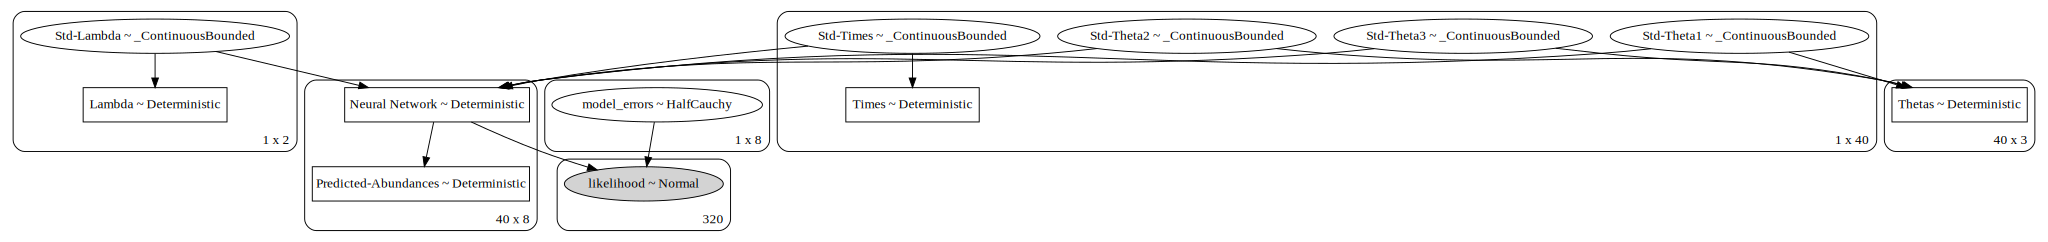

In [127]:
pm.model_to_graphviz(simple_model)

## SFR seems to sample outside of bounds??

In [128]:
# Now sample
with simple_model:
    samples=pm.sample(500,chains=8,cores=8,tune=500,nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [model_errors, Std-Times, Std-Theta3, Std-Theta2, Std-Theta1, Std-Lambda]
Sampling 8 chains:   1%|▏         | 119/8000 [00:21<43:31,  3.02draws/s]


ValueError: Not enough samples to build a trace.

In [130]:
with simple_model:
    inference=pm.ADVI()
    approx = pm.fit(n=1000, method=inference)


Average Loss = 1,760.5: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]
Finished [100%]: Average Loss = 1,759.9


In [131]:
with simple_model:
    advi_samples=approx.sample(4000)

In [132]:
advi_samples

<MultiTrace: 1 chains, 4000 iterations, 17 variables>

In [133]:
pm.summary(advi_samples,varnames=['Lambda','model_errors']).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Lambda__0_0,-2.2971,0.2823,0.0040,-2.8152,-1.7677
Lambda__0_1,-2.7815,0.2714,0.0043,-3.2969,-2.2760
model_errors__0_0,18.4631,14.5303,0.2381,1.8984,45.6303
model_errors__0_1,18.7547,15.1888,0.2137,1.6538,46.2174
model_errors__0_2,18.6791,14.7391,0.1970,1.8764,45.9222
model_errors__0_3,18.3117,14.2343,0.2115,2.1379,45.6279
model_errors__0_4,18.2487,14.3693,0.2085,1.8821,43.4044
model_errors__0_5,18.4113,14.0098,0.2310,2.2331,46.4843
model_errors__0_6,18.5879,13.9345,0.2057,1.7908,46.0541
model_errors__0_7,18.3332,14.4039,0.2220,1.8266,45.8603


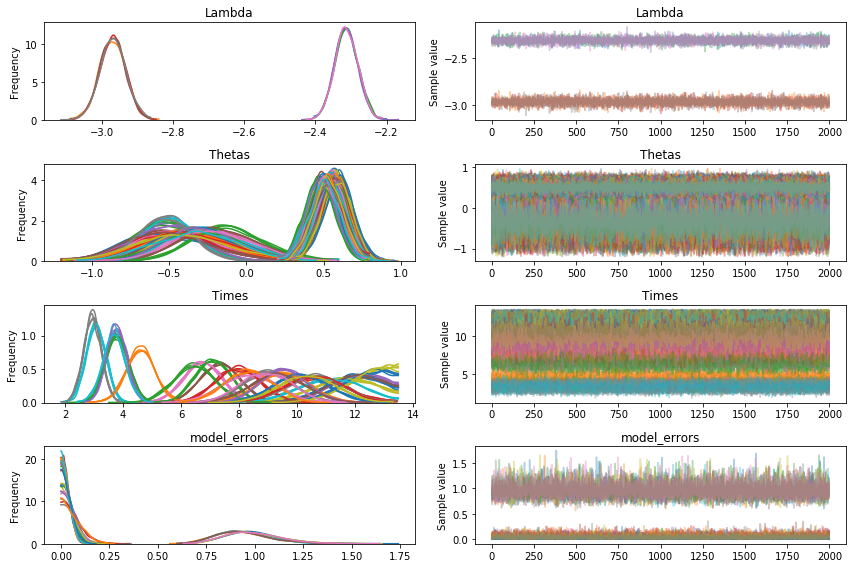

In [135]:
pm.traceplot(samples,varnames=['Lambda','Thetas','Times','model_errors']);

In [62]:
def construct_output(samples):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,:,:]
    Times=samples.get_values('Times')[:,0,:]
    return Lambda,Thetas,Times

def single_star_output(samples,star_no):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,star_no,:]
    Times=samples.get_values('Times')[:,0,star_no].reshape(len(Lambda),1)
    return Lambda,Thetas,Times

In [63]:
Lambda,Thetas,Times=construct_output(samples)

Corner Plot for All Stars

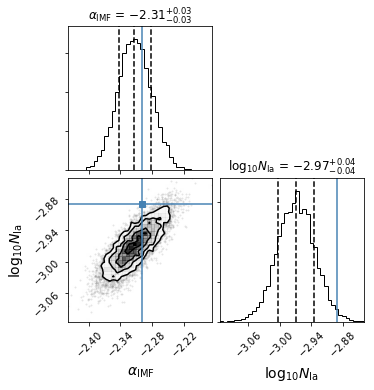

In [64]:
import corner
corner.corner(Lambda,show_titles=True,quantiles=[0.17,0.5,0.83],use_math_text=True,label_kwargs={'fontsize': 14},
              labels=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$'],bins=40,truths=true_Lambda);

Corner plot for single star (with $1\sigma$ Gaussian smoothing):

In [65]:
from scipy.stats import truncnorm

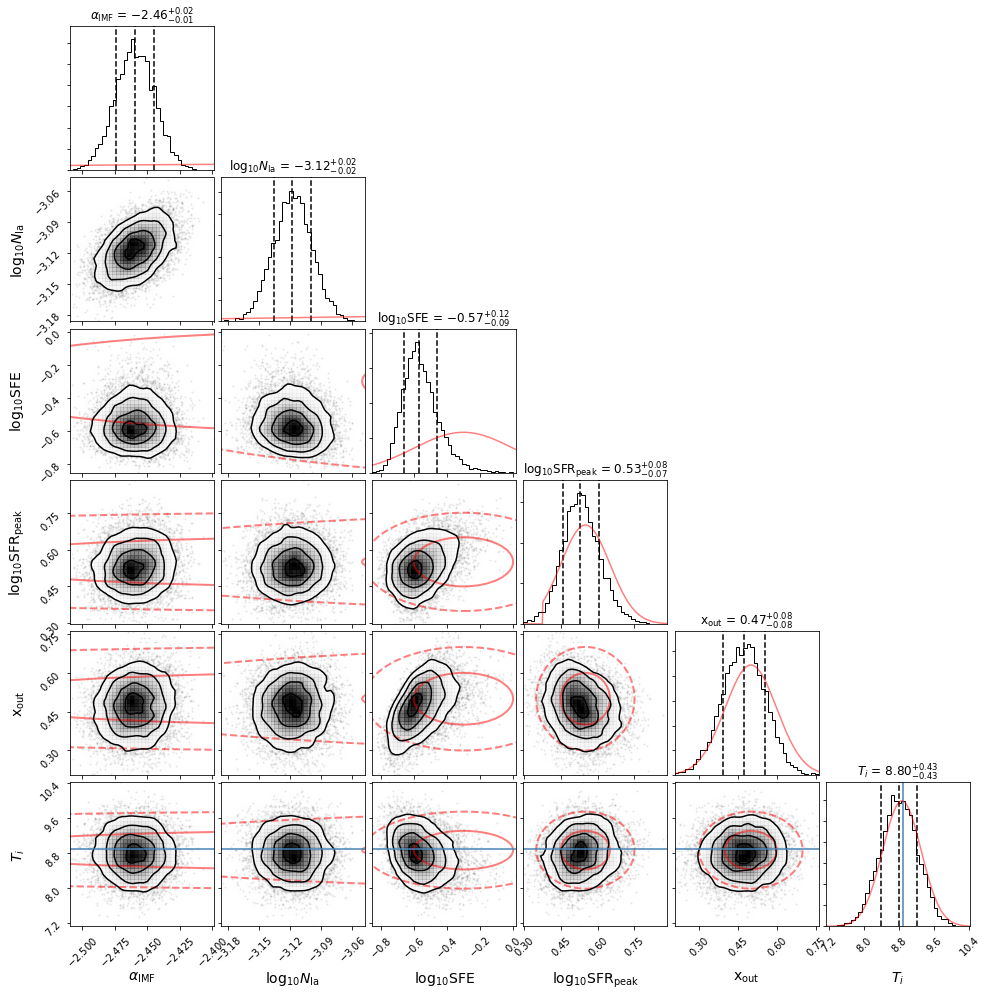

In [23]:
star_index=2
Lambda,Theta1,Times1=single_star_output(samples,star_index)

true_params = np.hstack([true_Lambda,true_Thetas[star_index],true_Times[star_index]])

n_bins=40
names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$',r'$\log_{10}\mathrm{SFE}$',
         r'$\log_{10}\mathrm{SFR}_\mathrm{peak}$',r'$\mathrm{x}_\mathrm{out}$',r'$T_i$']
priors = list(a.p0)+[mu_times[star_index]]
prior_widths = list(np.hstack([Lambda_prior_width,Theta_prior_width]))+[sigma_times[star_index]]
all_dat=np.hstack([Lambda,Theta1,Times1])
figure=corner.corner(all_dat,show_titles=True,quantiles=[0.17,0.5,0.83],truths=true_params,
                     use_math_text=True,label_kwargs={'fontsize': 14},
                     labels=names,bins=n_bins,scale_hist=False,smooth=1.);

integ=np.zeros(len(all_dat[0]))
for i in range(len(all_dat[0])):
    ct,x,=np.histogram(all_dat[:,i],bins=n_bins)
    integ[i]=np.sum(np.diff(x)*ct)

from matplotlib.patches import Ellipse

# Extract the axes
ndim=len(priors)
axes = np.array(figure.axes).reshape((ndim, ndim))

from scipy.stats import norm

for yi in range(ndim):
    xi=yi
    ax=axes[yi,xi]
    xdata=np.linspace(priors[xi]-10*prior_widths[xi],priors[xi]+10*prior_widths[xi],1000)
    if yi==3:
        ax.plot(xdata,integ[yi]*truncnorm.pdf(xdata,std_log_SFR_crit,np.inf,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)
    else:
        ax.plot(xdata,integ[yi]*norm.pdf(xdata,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        el=Ellipse([priors[xi],priors[yi]],2*prior_widths[xi],2*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5)
        el2=Ellipse([priors[xi],priors[yi]],4*prior_widths[xi],4*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5,ls='--')
        ax.add_artist(el)
        ax.add_artist(el2)

In [71]:
def plotautocorr(samples,max_lags=30,burn_in=100):
    FS=16
    lambda_samples=samples['Lambda'][:,0,:][burn_in:]
    fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
    for l,lam in enumerate(lambda_samples.T):
        ax[l].acorr(lam, detrend=plt.mlab.detrend_mean,maxlags=max_lags)
        ax[l].set_ylabel(r"$\Lambda_{%d}$"%(l+1),fontsize=FS)
        ax[l].set_xlim(0, max_lags)

    ax[1].set_xlabel("Lag",fontsize=FS)
    ax[0].set_title(r"$\Lambda$ Autocorrelation Plot using %d burn-in samples"%burn_in,fontsize=FS);   

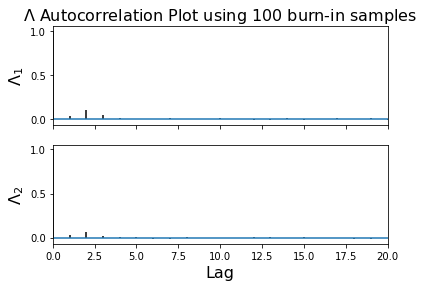

In [72]:
plotautocorr(samples,burn_in=100,max_lags=20);

Plot PPC:

In [24]:
def net_standard_output(standard_in_par):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(np.asmatrix(standard_in_par),w_array_0)+b_array_0
    standard_out=np.matmul(np.tanh(l1),w_array_1)+b_array_1
    return np.asarray(standard_out)
def net_output(in_par):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-input_mean)/input_std
    sq_in = np.asarray(list(standard_in)+[standard_in[-1]**2.])
    # Reconstruct network
    standard_out=net_standard_output(sq_in)
    # Destandardize output
    out = np.asarray(standard_out)*output_std+output_mean
    return out

#### Let's see what's happening for star 4 (at large time)

In [25]:
La,Th,Ti = single_star_output(samples,4)
params=np.hstack([La,Th,Ti])
med_params=np.median(params,axis=0)
true_params=np.hstack([true_Lambda,true_Thetas[4],true_Times[4]])
print(med_params)
print(true_params)

[-2.45965114 -3.11740492 -0.41823517  0.61843251  0.61833045  8.5503802 ]
[-2.3       -2.89             inf        inf        inf  8.8735094]


In [26]:
all_ppc_abun=[]
for star_index in range(n_stars):
    Lambda,Theta1,Times1=single_star_output(samples,star_index)
    all_par=np.hstack([Lambda,Theta1,Times1])
    ppc_abun = np.asarray([net_output(pp) for pp in all_par])
    all_ppc_abun.append(ppc_abun)

In [27]:
all_ppc_abun[0].shape

(8000, 1, 8)

In [28]:
def alpha_abun(abun_arr,err=False):
    for e in range(len(els)):
        if str(els[e])=='O':
            indO=e
        if str(els[e])=='Mg':
            indMg=e
        if str(els[e])=='Si':
            indSi=e
        if str(els[e])=='Fe':
            indFe=e
    if err:
        ab_alpha = np.sqrt(abun_arr[indFe]**2.+((abun_arr[indO]*16.)**2.+(abun_arr[indMg]*24.)**2.+(abun_arr[indSi]*28.)**2.)/(16.+24.+28.)**2.)
    else:
        ab_alpha = (abun_arr[indO]*16.+abun_arr[indMg]*24.+abun_arr[indSi]*28.)/(16.+24.+28.)-abun_arr[indFe]
    return abun_arr[indFe],ab_alpha

In [29]:
ppc_perc

NameError: name 'ppc_perc' is not defined

<ErrorbarContainer object of 3 artists>

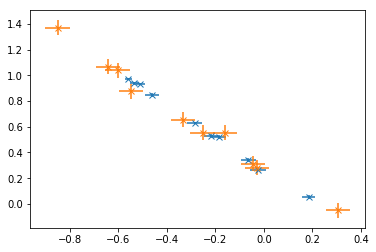

In [30]:
up,med,lo=[],[],[]
for i in range(n_stars):
    ppc_perc = np.percentile(all_ppc_abun[i][:,0,:],[17.,50.,83.],axis=0)
    med.append(alpha_abun(ppc_perc[1]))
    up.append(alpha_abun(ppc_perc[2]))
    lo.append(alpha_abun(ppc_perc[0]))
med=np.asarray(med)
up=np.asarray(up)
lo=np.asarray(lo)
plt.errorbar(med[:,0],med[:,1],yerr=[med[:,1]-lo[:,1],up[:,1]-med[:,1]],
             xerr=[med[:,0]-lo[:,0],up[:,0]-med[:,0]],marker='x',ls='')
obs_dat=[];obs_err=[]
for i in range(n_stars):
    obs_dat.append(alpha_abun(obs_abundances[i]))
    obs_err.append(alpha_abun(obs_errors[i],err=True))
plt.errorbar(np.asarray(obs_dat)[:,0],np.asarray(obs_dat)[:,1],marker='x',ls='',
            yerr=np.asarray(obs_err)[:,1],xerr=np.asarray(obs_err)[:,0])


In [32]:
np.asarray(obs_dat)

array([[ 0.30380464, -0.05104153],
       [-0.25248575,  0.55537563],
       [-0.16093254,  0.55245608],
       [-0.02892208,  0.28181588],
       [-0.33425832,  0.65536905],
       [-0.60288429,  1.03807063],
       [-0.84979177,  1.37099539],
       [-0.64305615,  1.06867139],
       [-0.04529977,  0.3112227 ],
       [-0.54801583,  0.877307  ]])

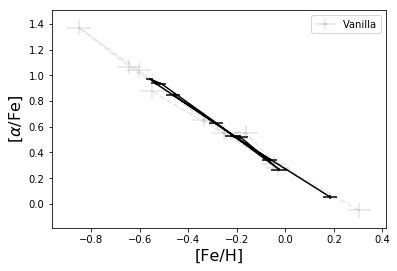

In [33]:
len_T = len(np.unique(true_Times))
labels = ['Vanilla','Low SFE','Bursty SFR','Leaky ISM']
c=['k','r','g','b']
for index in range(n_stars//len_T):
    oFeH,oAlFe,oFeHSig,oAlFeSig=[np.zeros(len_T) for _ in range(4)]
    FeH,AlFe,FeHL,FeHH,AlFeL,AlFeH=[np.zeros(len_T) for _ in range(6)]
    for j in range(len_T):
        star_index = index*len_T+j
        this_ppc_perc = np.percentile(all_ppc_abun[star_index][:,0,:],[17.,50.,83.],axis=0)
        oFeH[j],oAlFe[j] = alpha_abun(obs_abundances[star_index])
        oFeHSig[j],oAlFeSig[j] = alpha_abun(obs_errors[star_index],err=True)
        FeH[j],AlFe[j] = alpha_abun(this_ppc_perc[1])
        FeHL[j],AlFeL[j] = alpha_abun(this_ppc_perc[0])
        FeHH[j],AlFeH[j] = alpha_abun(this_ppc_perc[2])
    plt.errorbar(oFeH,oAlFe,xerr=oFeHSig,yerr=oAlFeSig,ls='--',label=labels[index],c=c[index],alpha=0.1)
    plt.errorbar(FeH,AlFe,xerr=[FeH-FeHL,FeHH-FeH],yerr=[AlFe-AlFeL,AlFeH-AlFe],ls='-',c=c[index])
plt.legend();plt.ylabel(r'[$\alpha$/Fe]',fontsize=16);plt.xlabel('[Fe/H]',fontsize=16);